In [1]:
import pathlib
from functools import partial

from astropy.constants import G
import astropy.table as at
import astropy.units as u
import cmasher as cmr
import gala.integrate as gi
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from scipy.interpolate import InterpolatedUnivariateSpline

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti
from config import mgfe_cbar_vlim, mgfe_cbar_xlim, gala_pot, agama_pot
from model_maker import SplineLabelModelWrapper

import agama

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

First: What do we expect for $e_2(\tilde{r}_z)$?

In [2]:
vc = 229 * u.km / u.s
R0 = 8.3 * u.kpc
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    Omega0 = np.sqrt(gala_pot.density([1, 0, 0.0] * R0) * (4 * np.pi * G)).to(
        u.rad / u.Myr
    )[0]

z_tmp = np.linspace(1e-3, 3.0, 128) * u.kpc
rzp = z_tmp * np.sqrt(Omega0)

In [3]:
true_log_Omega = np.log(Omega0.value)
true_log_Omega

-2.559568268156126

In [4]:
xv = np.zeros((z_tmp.size, 6))
xv[:, 0] = R0.decompose(galactic).value
xv[:, 2] = z_tmp.decompose(galactic).value
xv[:, 4] = vc.decompose(galactic).value

In [5]:
af = agama.ActionFinder(agama_pot)
J, ang, freq = af(xv, angles=True)

In [6]:
rz = np.sqrt(z_tmp**2 * freq[:, 1] * u.rad / u.Myr)

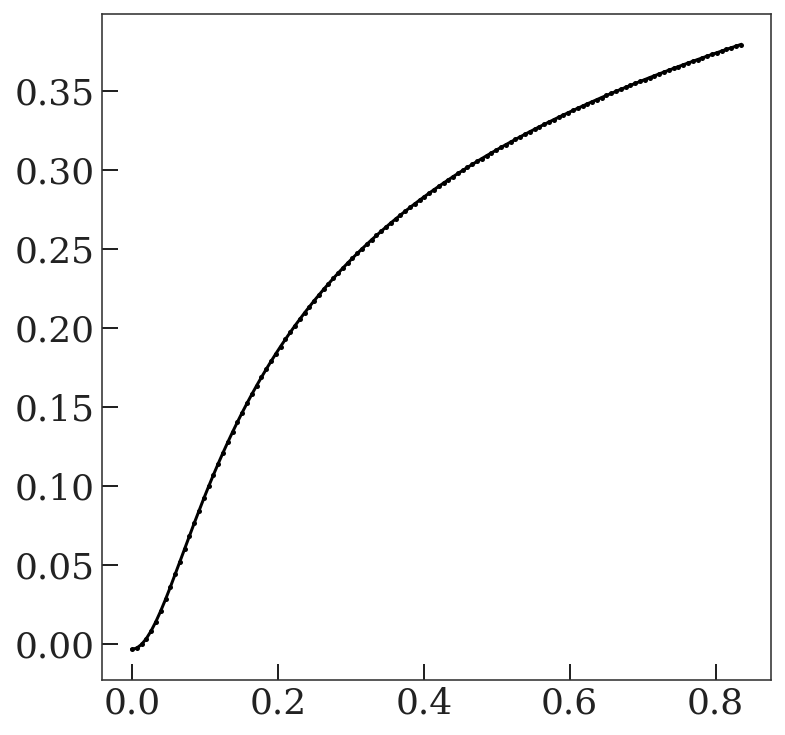

In [7]:
plt.plot(rzp, -(rz / rzp - 1))

# r_e_grid = np.linspace(0, max_re.value, 128)
# e2_vals = model.label_model.get_es(r_e_grid, res.params["e_params"])[2]
# e4_vals = model.label_model.get_es(r_e_grid, res.params["e_params"])[4]
# plt.plot(r_e_grid, e2_vals, marker="")
# plt.plot(r_e_grid, e2_vals - e4_vals, marker="")
# plt.axhline(0.)
# plt.axvline(0.1 * np.sqrt(0.077))

---

In [8]:
pdata = at.QTable.read("../data/df-qiso.fits")

In [9]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    zmax = np.sqrt(2 * pdata["J"][:, 2] / pdata["Omega"][:, 2]).to_value(
        galactic["length"]
    )

rng = np.random.default_rng(seed=42)
pdata["mgfe"] = rng.normal(0.064 * zmax + 0.009, 0.05)

In [10]:
Jphi0 = 229 * u.km / u.s * 8.3 * u.kpc
R0 = 8.3 * u.kpc
mask = (
    (np.abs(pdata["R"] - pdata["Rg"]) < 1 * u.kpc)
    & (np.abs(pdata["R"] - R0) < 1 * u.kpc)
    & (np.abs(pdata["v_R"]) < 15 * u.km / u.s)
)
print(mask.sum())

14608372


In [11]:
oti_data = oti.OTIData(
    pos=pdata["z"][mask], vel=pdata["v_z"][mask], mgfe=pdata["mgfe"][mask]
)

In [12]:
init_Omega = 0.077 * u.rad / u.Myr
max_z = 3.0 * u.kpc
max_vz = 125.0 * u.km / u.s

In [13]:
max_re = (max_z * np.sqrt(init_Omega)).decompose(galactic)
max_re.value

0.8324662155306964

In [14]:
zbins = np.linspace(-max_z.value, max_z.value, 151) * u.kpc
vzbins = np.linspace(-max_vz.value, max_vz.value, 151) * u.km / u.s
zvz_bins = {"pos": zbins, "vel": vzbins}
bdata, _ = oti_data.get_binned_label(bins=zvz_bins)

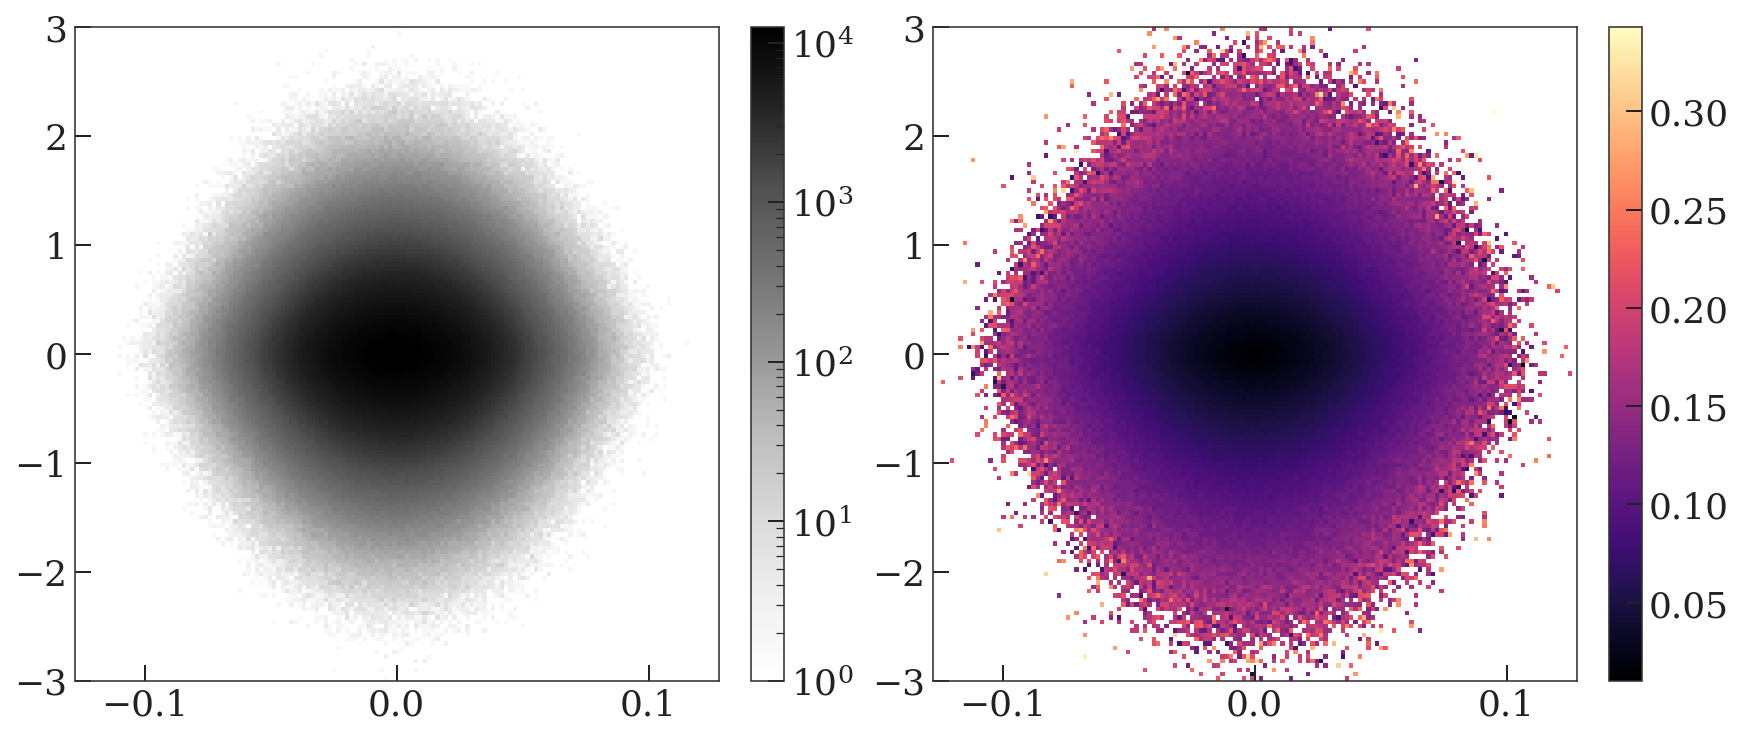

In [15]:
res = oti_data.get_binned_counts(zvz_bins)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
cs = axes[0].pcolormesh(
    bdata["vel"].value,
    bdata["pos"].value,
    res["counts"],
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
fig.colorbar(cs, ax=axes[0])

cs = axes[1].pcolormesh(bdata["vel"].value, bdata["pos"].value, bdata["mgfe"])
fig.colorbar(cs, ax=axes[1])

In [16]:
model = SplineLabelModelWrapper(
    r_e_max=max_re.value,
    label_n_knots=9,
    label0_bounds=(-1.0, 1.0),
    label_grad_sign=1.0,
    e_n_knots={2: 11, 4: 5, 6: 5},
    e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
    e_regularize_sigmas={2: 0.05, 4: 0.05, 6: 0.02},
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


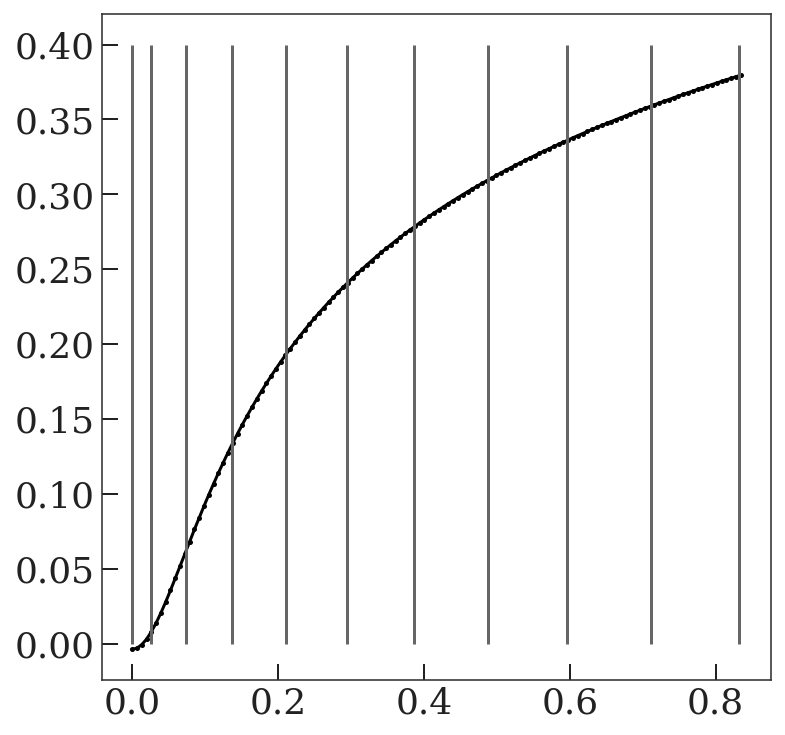

In [17]:
plt.plot(rzp, -(rz / rzp - 1))
plt.vlines(model.e_knots[2], 0, 0.4)

In [18]:
spl = InterpolatedUnivariateSpline(rzp, -(rz / rzp - 1), k=3)
init_e2 = spl.derivative()(model.e_knots[2][1:])

In [19]:
p0 = model.get_init_params(oti_data)
p0["e_params"][2]["vals"] = init_e2
if 4 in p0["e_params"]:
    p0["e_params"][4]["vals"] = np.full(
        len(p0["e_params"][4]["vals"]), 0.05 / max_re.value
    )
if 6 in p0["e_params"]:
    p0["e_params"][6]["vals"] = np.full(
        len(p0["e_params"][6]["vals"]), 0.02 / max_re.value
    )
p0

{'pos0': -1.3074028236101808e-05,
 'vel0': -8.225996633284692e-06,
 'ln_Omega0': -2.818628052298981,
 'e_params': {2: {'vals': array([0.8222925 , 1.24575868, 0.974852  , 0.67652913, 0.47804322,
          0.35300583, 0.27266095, 0.21913991, 0.18206826, 0.15542996])},
  4: {'vals': array([0.0600625, 0.0600625, 0.0600625, 0.0600625])},
  6: {'vals': array([0.024025, 0.024025, 0.024025, 0.024025])}},
 'label_params': {'label_vals': array([0.01715935, 0.4109502 , 0.4109502 , 0.4109502 , 0.4109502 ,
         0.4109502 , 0.4109502 , 0.4109502 , 0.4109502 ])}}

In [20]:
bdata, res = model.run(
    oti_data,
    p0=p0,
    bins=zvz_bins,
    jaxopt_kw=dict(maxiter=32768, tol=1e-12)
    #     jaxopt_kw=dict(maxiter=16384),
)

In [21]:
res.params

{'e_params': {2: {'vals': Array([0.79259638, 0.82388043, 0.76308501, 0.64519958, 0.47422943,
          0.25583424, 0.17845449, 0.15517437, 0.08365662, 0.08948098],      dtype=float64)},
  4: {'vals': Array([0.13317337, 0.00122653, 0.        , 0.00379527], dtype=float64)},
  6: {'vals': Array([0.        , 0.05561979, 0.07283985, 0.07815541], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00677284, 0.28482251, 0.39749397, 0.39021722, 0.42480558,
         0.42775293, 1.63831644, 0.4091978 , 0.4109502 ], dtype=float64)},
 'ln_Omega0': Array(-2.54715666, dtype=float64),
 'pos0': Array(-0.00013028, dtype=float64),
 'vel0': Array(2.68531081e-05, dtype=float64)}

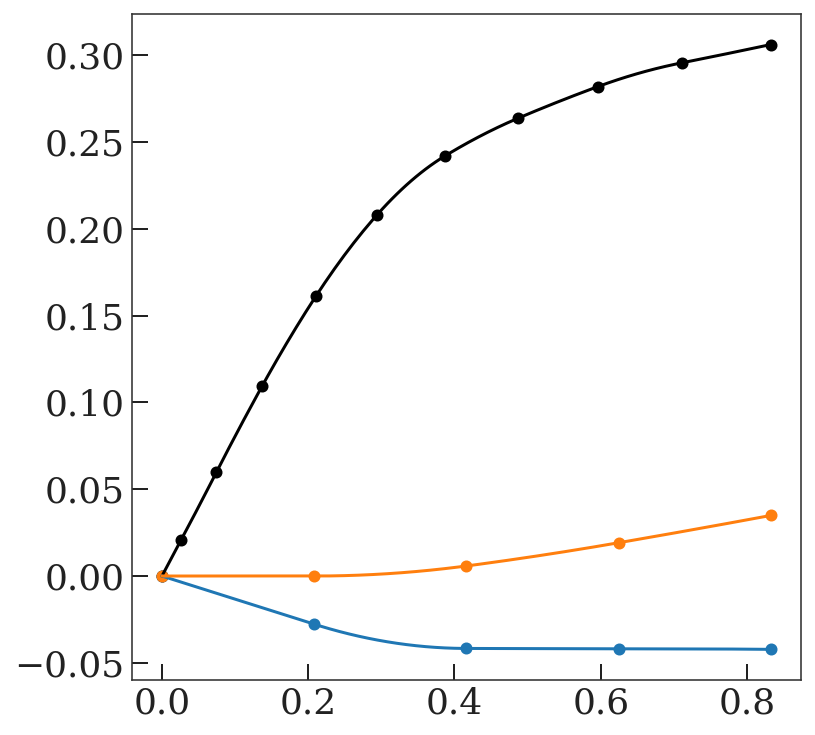

In [22]:
r_e_grid = np.linspace(0, max_re.value, 128)
e_vals = model.label_model.get_es(r_e_grid, res.params["e_params"])

for m, vals in e_vals.items():
    (l,) = plt.plot(r_e_grid, vals, marker="")
    plt.scatter(
        model.e_knots[m],
        model.label_model.e_funcs[m](
            model.e_knots[m], res.params["e_params"][m]["vals"]
        ),
        color=l.get_color(),
    )

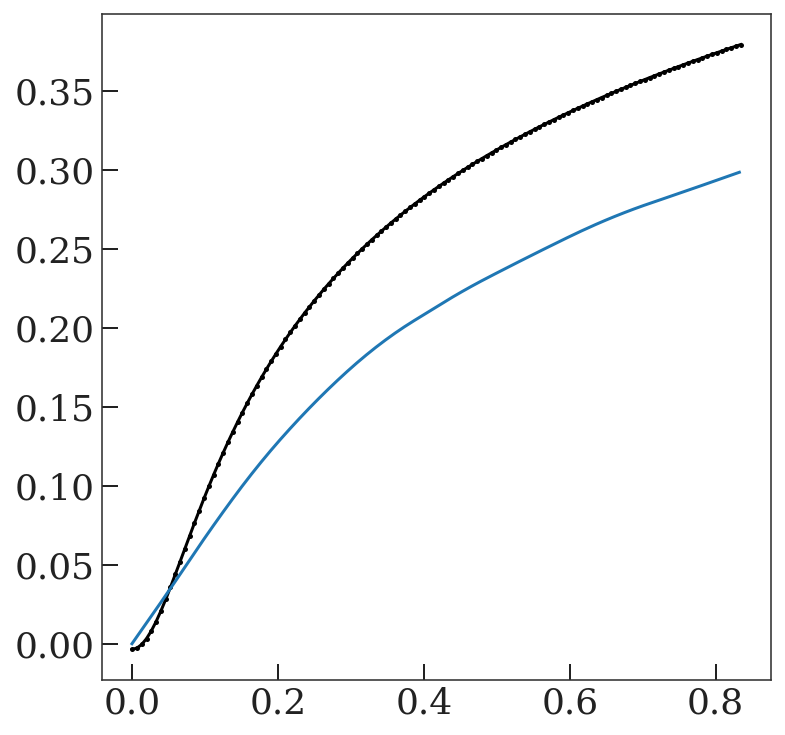

In [23]:
plt.plot(rzp, -(rz / rzp - 1))

vals = np.zeros_like(r_e_grid)
for m, tmp in e_vals.items():
    vals += tmp
plt.plot(r_e_grid, vals, marker="")

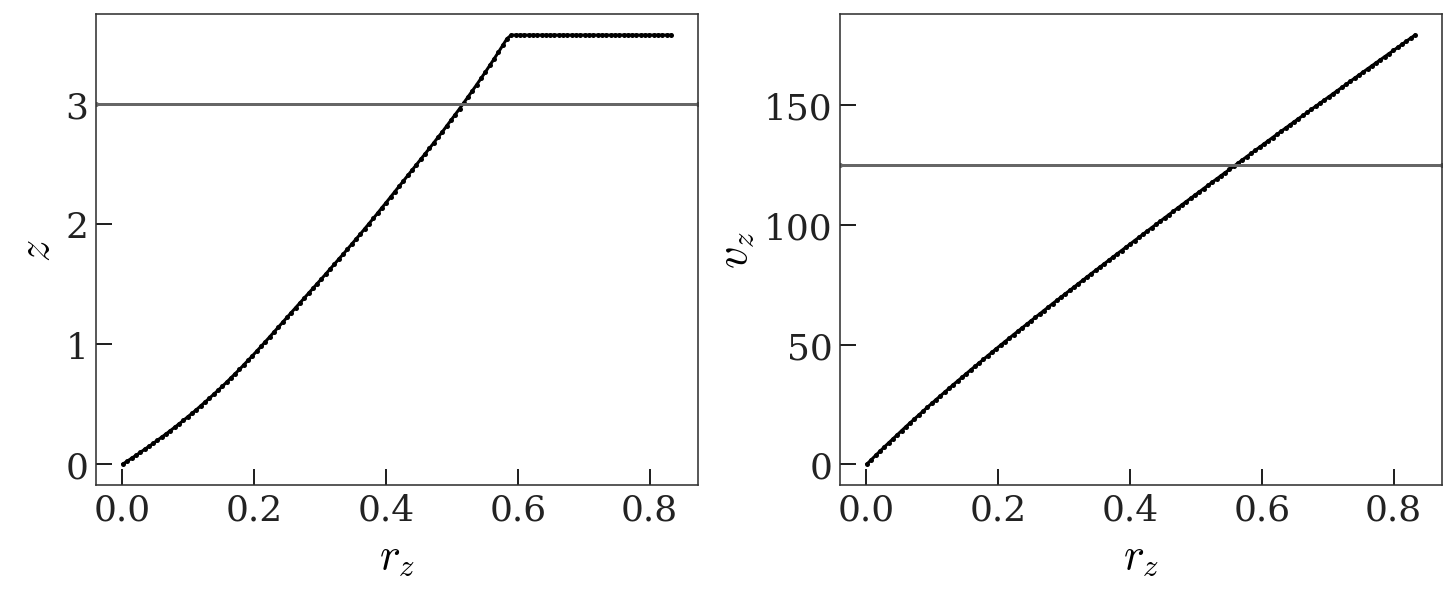

In [24]:
r_grid = np.linspace(1e-3, 1.0, 128) * max_re.value
shit = np.array([model.label_model.get_pos(rr, np.pi / 2, res.params) for rr in r_grid])
fuck = np.array([model.label_model.get_vel(rr, 0.0, res.params) for rr in r_grid])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4), layout="constrained")

ax = axes[0]
ax.plot(r_grid, shit)
ax.axhline(max_z.value)
ax.set_ylabel("$z$")

ax = axes[1]
ax.plot(r_grid, (fuck * u.kpc / u.Myr).to_value(u.km / u.s))
ax.axhline(max_vz.to_value(u.km / u.s))
ax.set_ylabel("$v_z$")

for ax in axes:
    ax.set_xlabel("$r_z$")

In [25]:
r_e, _ = model.label_model.get_elliptical_coords(oti_data.pos, oti_data.vel, res.params)
r_e.max()

Array(1.04152095, dtype=float64)

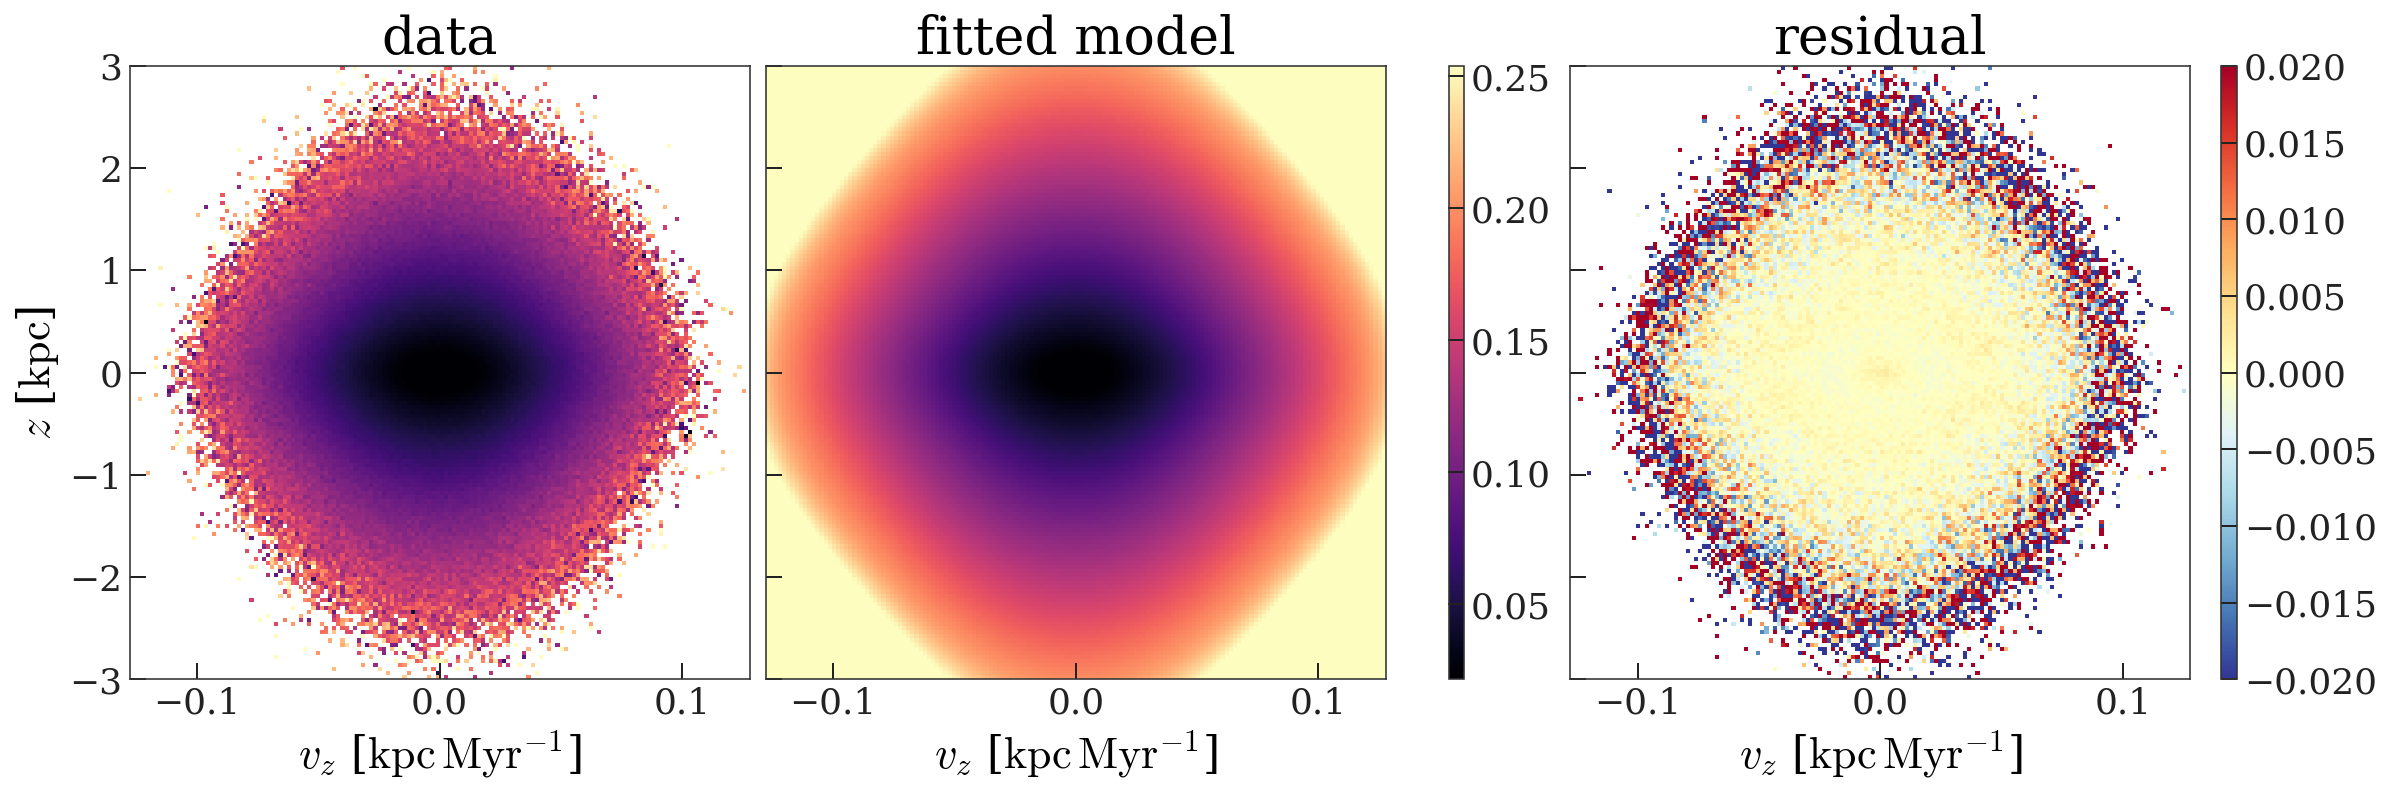

In [26]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model.label_model,
    res.params,
    label_name="mgfe",
    fractional_residual=False,
    vlim_residual=0.02,
)

In [27]:
Omega = np.exp(res.params["ln_Omega0"]) * u.rad / u.Myr

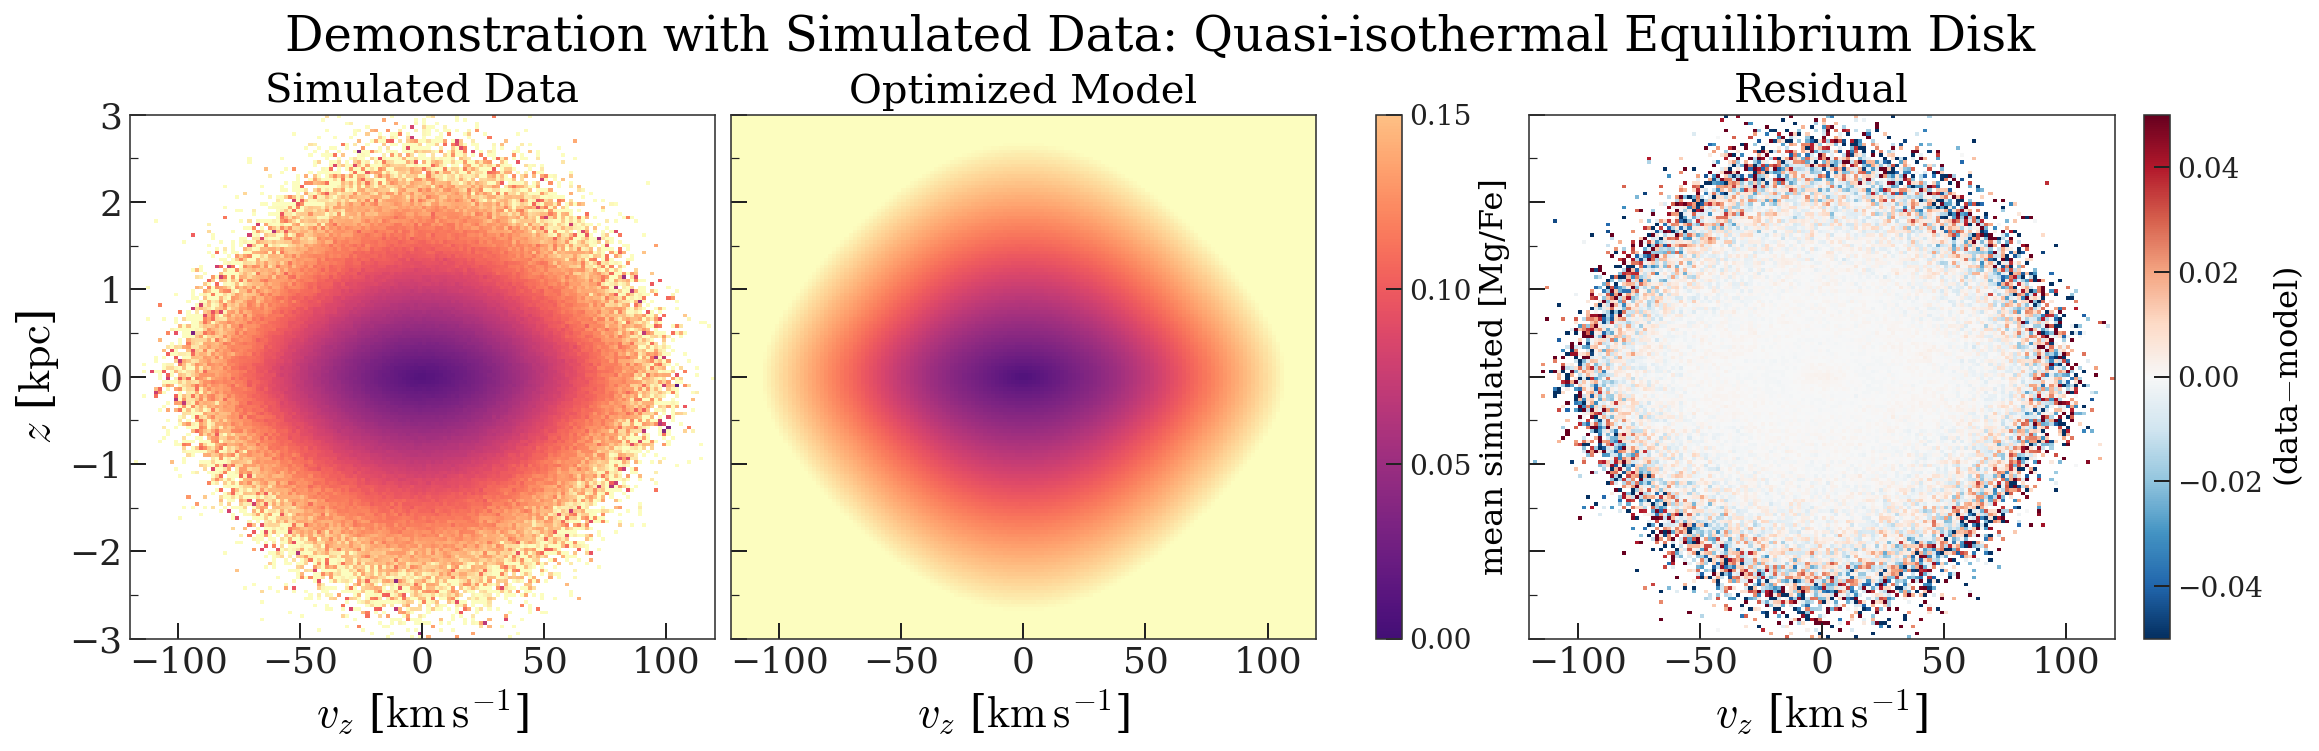

In [47]:
cb_labelsize = 16

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.1), sharex=True, sharey=True, layout="constrained"
)

cs = axes[0].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
cb = fig.colorbar(cs, ax=axes[0:2])  # , orientation="horizontal", aspect=40)
cb.set_label("mean simulated [Mg/Fe]", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


model_mgfe = np.array(model.label_model.label(bdata["pos"], bdata["vel"], res.params))
cs = axes[1].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
# cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
# cb.set_label("number density", fontsize=cb_labelsize)

cs = axes[2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"] - model_mgfe,
    cmap="RdBu_r",
    vmin=-0.05,
    vmax=0.05,
    rasterized=True,
)
cb = fig.colorbar(cs, ax=axes[2])  # , orientation="horizontal")
cb.set_label("(data$-$model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)

# Titles
axes[0].set_title("Simulated Data", fontsize=20)
axes[1].set_title("Optimized Model", fontsize=20)
axes[2].set_title("Residual", fontsize=20)
fig.suptitle(
    "Demonstration with Simulated Data: Quasi-isothermal Equilibrium Disk", fontsize=24
)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")

# Ticks
axes[0].set_xticks(np.arange(-100, 100 + 1, 50))
axes[0].set_xticks(np.arange(-100, 100 + 1, 50), minor=True)
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

axes[0].set_xlim(-120, 120)

# for ax in axes:
#     ax.set_aspect(2 * np.pi / Omega.value)

fig.savefig(
    "../tex/figures/qiso-data-model.pdf", dpi=250, pad_inches=0.1, bbox_inches="tight"
)

In [29]:
zgrid = np.linspace(-3, 3, 512) * u.kpc

Error samples:

In [30]:
tmp_data = bdata.copy()
tmp_data["label"] = tmp_data.pop("mgfe")
tmp_data["label_err"] = tmp_data.pop("mgfe_err")
tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
errs

{'e_params': {2: {'vals': Array([0.45703796, 0.0753069 , 0.07722838, 0.02079119, 0.01392333,
          0.01777659, 0.04858056, 0.06477434, 0.17367982, 0.47078283],      dtype=float64)},
  4: {'vals': Array([0.0015143 , 0.01384277, 0.09660111, 0.7607283 ], dtype=float64)},
  6: {'vals': Array([0.00351572, 0.0085835 , 0.04028647, 0.3407932 ], dtype=float64)}},
 'label_params': {'label_vals': Array([0.        , 0.00196308, 0.00707302, 0.00578061, 0.00519289,
         0.01185542, 0.07266275, 1.58726462, 0.        ], dtype=float64)},
 'ln_Omega0': Array([0.04952668], dtype=float64),
 'pos0': Array([0.00017769], dtype=float64),
 'vel0': Array([1.01756539e-05], dtype=float64)}

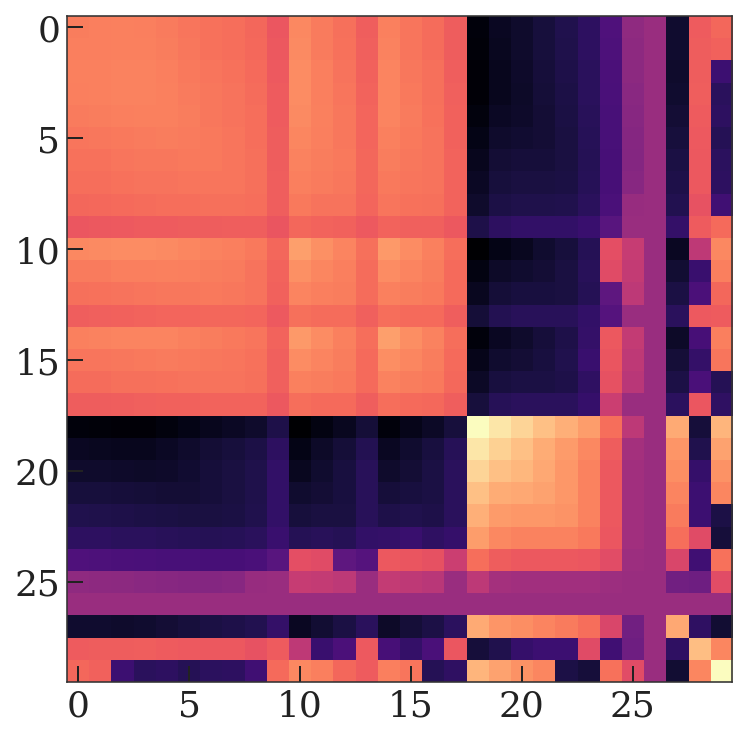

In [31]:
crlb = model.label_model.get_crlb(res.params, tmp_data, inv=True)
plt.imshow(crlb, norm="symlog")

In [32]:
par_samples = model.label_model.get_crlb_error_samples(res.params, tmp_data, size=1024)

/mnt/ceph/users/apricewhelan/projects/torusimaging/torusimaging/model.py:496: RuntimeWarning: covariance is not positive-semidefinite.
  samples = rng.multivariate_normal(flat_params, crlb, size=size)


In [33]:
oti_accs = []
for p in par_samples:
    acc = model.label_model.get_acceleration(zgrid, p)
    oti_accs.append(acc.value)
oti_accs = oti_accs * acc.unit

Bootstrap trials:

In [34]:
rng = np.random.default_rng(seed=8675309)
trials = []
for trial in range(64):
    trial_idx = rng.choice(len(oti_data), size=len(oti_data), replace=True)
    _, trial_res = model.run(
        oti_data[trial_idx], bins=zvz_bins, jaxopt_kw=dict(maxiter=4096, tol=1e-8)
    )
    trials.append(trial_res)

In [35]:
bootstrap_accs = []
for trial_res in trials:
    acc = model.label_model.get_acceleration(zgrid, trial_res.params)
    bootstrap_accs.append(acc.value)
bootstrap_accs = bootstrap_accs * acc.unit

In [36]:
a_unit = u.km / u.s / u.Myr
xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0] = R0
xyz_grid[2] = zgrid
true_acc = gala_pot.acceleration(xyz_grid)

In [37]:
err_prop_err = np.diff(
    np.nanpercentile(oti_accs.T, [16, 84], axis=1).to_value(a_unit), axis=0
)[
    0
]  # /2
bootstrap_err = np.std(bootstrap_accs.to_value(a_unit), axis=0)
total_acc_err = np.sqrt(err_prop_err**2 + bootstrap_err**2) * a_unit
# total_acc_err = bootstrap_err * a_unit
# total_acc_err = err_prop_err * a_unit

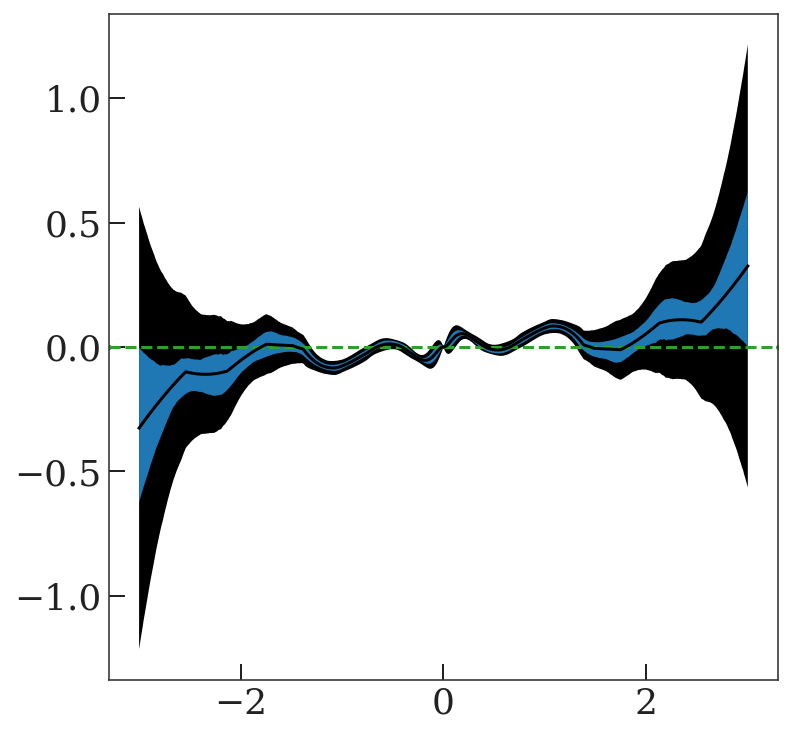

In [38]:
bestfit_acc = model.label_model.get_acceleration(zgrid, res.params)

dacc = (bestfit_acc - true_acc[2]).to_value(a_unit)

plt.axhline(0.0, ls="--", color="tab:green")
plt.plot(zgrid.value, dacc, marker="", color="k")
plt.fill_between(
    zgrid.value,
    dacc - total_acc_err.to_value(a_unit),
    dacc + total_acc_err.to_value(a_unit),
)
plt.fill_between(
    zgrid.value,
    (np.nanpercentile(oti_accs.T, 16, axis=1) - true_acc[2]).to_value(a_unit),
    (np.nanpercentile(oti_accs.T, 84, axis=1) - true_acc[2]).to_value(a_unit),
)
# plt.ylim(-0.1, 0.1)

In [39]:
# bestfit_acc = model.label_model.get_acceleration(zgrid, res.params)

# dacc = ((bestfit_acc - true_acc[2]) / true_acc[2]).decompose().value

# plt.plot(zgrid.value, dacc, marker="", ls="--", color="tab:green")

# colors = ['tab:blue', 'tab:orange', 'tab:red']
# for i, (m, knots) in enumerate(model.e_knots.items()):
#     for k in knots:
#         rr = model.label_model.get_r(k, np.pi/2, res.params['e_params'])
#         zz = model.label_model.get_pos(rr, np.pi/2, res.params)

#         plt.axvline(zz, color=colors[i])
#         plt.axvline(-zz, color=colors[i])

In [40]:
(aaf_idx,) = np.where(mask)

rng = np.random.default_rng(seed=123)
aaf_idx = rng.choice(aaf_idx, size=100_000, replace=False)
aaf = model.label_model.compute_action_angle(
    pdata["z"][aaf_idx], pdata["v_z"][aaf_idx], res.params
)

In [41]:
Junit = u.km / u.s * u.kpc

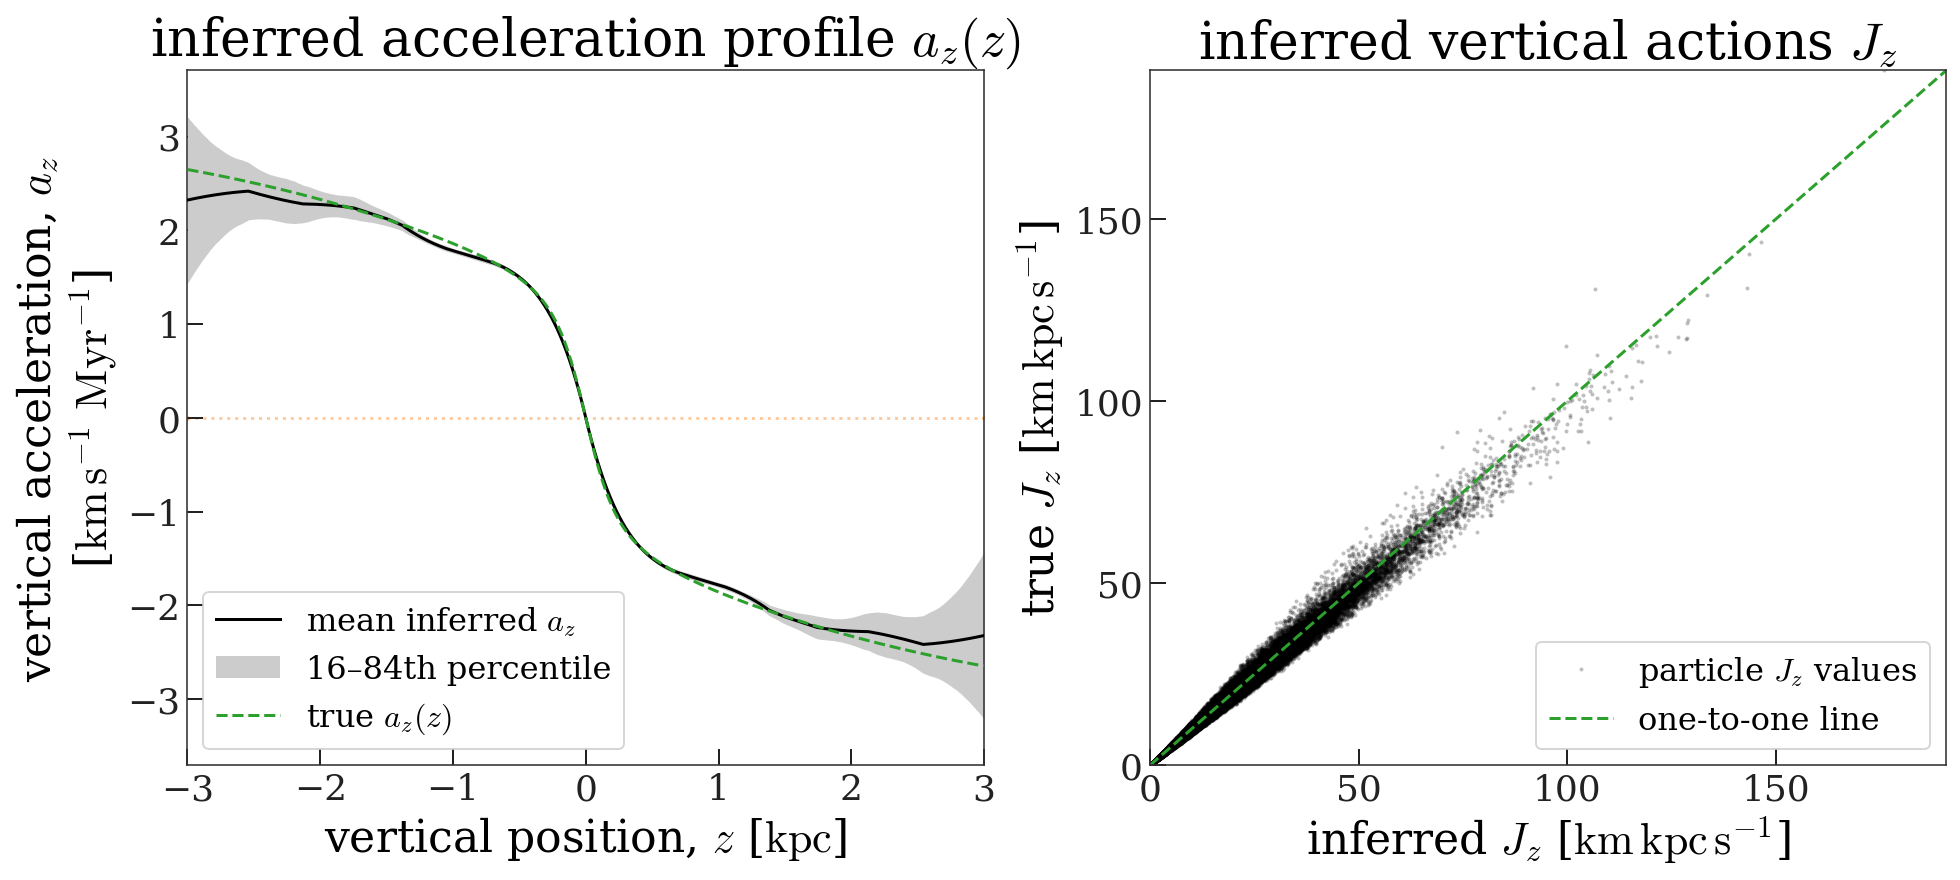

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.0), layout="constrained")

ax = axes[0]
ax.plot(
    zgrid.value,
    bestfit_acc.to_value(a_unit),
    # np.nanmean(oti_accs.T, axis=1).to_value(a_unit),
    color="k",
    marker="",
    label="mean inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value,
    # np.nanpercentile(oti_accs.T, 16, axis=1).value,
    # np.nanpercentile(oti_accs.T, 84, axis=1).value,
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"16–84th percentile",
    zorder=2,
)
ax.plot(
    zgrid.value,
    true_acc[2].to_value(a_unit),
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z(z)$",
    zorder=15,
)
ax.set_xlim(zgrid.value.min(), zgrid.value.max())
ax.set_ylim(
    1.4 * true_acc[2].min().to_value(a_unit), 1.4 * true_acc[2].max().to_value(a_unit)
)
ax.axhline(0, zorder=-10, color="tab:orange", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("inferred acceleration profile $a_z(z)$")

ax = axes[1]
ax.plot(
    aaf["J"].to_value(Junit),
    pdata["J"].to_value(Junit)[aaf_idx, 2],
    marker="o",
    ls="none",
    alpha=0.25,
    mew=0,
    ms=2.0,
    label="particle $J_z$ values",
    rasterized=True,
)
ax.axline(
    [0, 0],
    [
        pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
        pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
    ],
    ls="--",
    color="tab:green",
    marker="",
    label="one-to-one line",
)
ax.set_xlim(0, pdata["J"].to_value(Junit)[aaf_idx, 2].max())
ax.set_ylim(0, pdata["J"].to_value(Junit)[aaf_idx, 2].max())
ax.set_title("inferred vertical actions $J_z$")

ax.legend(loc="lower right", fontsize=16)

ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
ax.set_ylabel(f"true $J_z$ [{Junit:latex_inline}]")
ax.set_xticks(np.arange(0, 200, 50))
ax.set_yticks(np.arange(0, 200, 50))

fig.savefig("../tex/figures/qiso-validation.pdf", dpi=250)

In [44]:
idx = np.abs(zgrid - 1 * u.kpc).argmin()
(total_acc_err[idx] / true_acc[2][idx]).decompose()

<Quantity -0.01381157>

In [45]:
(bestfit_acc[idx] - true_acc[2][idx]) / true_acc[2][idx]

<Quantity -0.04152264>

In [46]:
truth = {
    "J": pdata["J"][:, 2].to(Junit)[aaf_idx],
    "theta": pdata["theta"][:, 2].to(u.rad)[aaf_idx],
    "Omega": pdata["Omega"][:, 2].to(u.rad / u.Myr)[aaf_idx],
}

for k in ["J", "theta", "Omega"]:
    if k == "theta":
        frac_diff = (
            ((np.cos(aaf[k]) - np.cos(truth[k])) / np.cos(truth[k])).decompose().value
        )
    else:
        frac_diff = ((aaf[k] - truth[k]) / truth[k]).decompose().value
    print(k, np.median(np.abs(frac_diff)))

J 0.04248088869770684
theta 0.04221031892352576
Omega 0.09811996795947805
